In [891]:
import warnings
warnings.filterwarnings("ignore")

In [892]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.optimize as opt

from simpledbf import Dbf5

from factor_analyzer.factor_analyzer import FactorAnalyzer
from pingouin import cronbach_alpha
import sklearn.linear_model as lm
from sklearn.feature_selection import r_regression
from sklearn.model_selection import train_test_split, KFold

import requests
import csv
import json

In [893]:
## Limitations:
### Just Nov 2024 data (no 2020, 2022, March 2024 election results)
### Probably other limitations as well

In [894]:
data = pd.read_csv('transformed_data/all_results.csv')
data.head()

,Unnamed: 0,SRPREC_KEY,PR_1_N,PR_1_Y,PR_26_N,PR_26_Y,PR_27_N,PR_27_Y,PR_28_N,PR_28_Y,...,G24PR3_T,G24PR4_N,G24PR4_Y,G24PR4_Y_2,G24PR5_N,G24PR5_Y,G24PR5_T,G24PR6_N,G24PR6_Y,G24PR6_T
0,0,06001200100,110.394301,2391.379349,1861.799846,628.266515,2280.397404,265.628899,393.789849,2191.582654,...,2920,433,2475,2908,1055,1792,2847,682,2101,2783
1,1,06001200200,84.131590,1476.736304,1153.935857,417.466221,1457.753361,152.717510,250.142427,1362.003012,...,2007,308,1681,1989,671,1264,1935,466,1454,1920
2,2,06001201400,103.578871,2247.796796,1672.623802,662.821849,2142.791281,254.711844,352.495938,2077.982694,...,2933,367,2547,2914,805,2059,2864,589,2225,2814
3,3,06001202200,23.911917,251.075125,172.365066,102.621975,229.155868,49.816493,45.831174,236.130177,...,405,55,347,402,95,301,396,70,319,389
4,4,06001202500,21.736580,229.559095,124.916878,126.381705,200.960005,60.204696,28.722699,235.426705,...,648,64,572,636,134,494,628,143,466,609


In [895]:
# data = pd.read_csv("data/state_g24_sov_data_by_g24_svprec.csv")
# data.head()

In [896]:
data.shape

(18250, 78)

In [897]:
full_data = data.copy()
full_data.shape

(18250, 78)

In [964]:
# data['SRPREC'].map(lambda x: x[:3])

In [966]:
# data = data[(data['SVPREC'].map(lambda x: x[-3:]) != 'TOT') &
#     (data['SVPREC'].map(lambda x: x[:3] != 'SOV'))]

In [968]:
data.columns.values

array(['Unnamed: 0', 'SRPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N',
       'PR_26_Y', 'PR_27_N', 'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N',
       'PR_29_Y', 'PR_30_N', 'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT',
       'PR_26_TOT', 'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT',
       'PR_31_TOT', 'SRPREC_x', 'FIPS', 'NEW_KEY', 'SRPREC_y', 'COUNTY',
       'FIPS_CODE', 'G24PDem', 'G24PRep', 'G24POth', 'G24PTot', 'G24SDem',
       'G24SRep', 'G24STot', 'G24SSDem', 'G24SSRep', 'G24SSTot',
       'G24HDem', 'G24HRep', 'G24HTot', 'G24SLDUDem', 'G24SLDURep',
       'G24SLDUTot', 'G24SLDLDem', 'G24SLDLRep', 'G24SLDLTot', 'G24PR2_N',
       'G24PR2_Y', 'G24PR2_T', 'G24PR32_N', 'G24PR32_Y', 'G24PR32_T',
       'G24PR33_N', 'G24PR33_Y', 'G24PR33_T', 'G24PR34_N', 'G24PR34_Y',
       'G24PR34_T', 'G24PR35_N', 'G24PR35_Y', 'G24PR35_T', 'G24PR36_N',
       'G24PR36_Y', 'G24PR36_T', 'G24PR3_N', 'G24PR3_Y', 'G24PR3_T',
       'G24PR4_N', 'G24PR4_Y', 'G24PR4_Y_2', 'G24PR5_N', 'G24PR5_Y',
       

In [970]:
data.shape

(18250, 78)

In [972]:
data = data.rename({
    'SRPREC_KEY': 'SVPREC_KEY',
    'G24PDem': 'PRSDEM01',
    'G24PRep': 'PRSREP01',
    'G24POth': 'PRSOTH01',
    'G24PTot': 'pres_tot',
    'G24SDem': 'SENDEM01',
    'G24SRep': 'SENREP01',
    'G24STot': 'sen_tot'
}, axis=1)

for i in [2, 3, 4, 5, 6, 32, 33, 34, 35, 36]:
    data = data.rename({
        f'G24PR{i}_N': f'PR_{i}_N',
        f'G24PR{i}_Y': f'PR_{i}_Y'
    }, axis=1)

data.columns.values

array(['Unnamed: 0', 'SVPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N',
       'PR_26_Y', 'PR_27_N', 'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N',
       'PR_29_Y', 'PR_30_N', 'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT',
       'PR_26_TOT', 'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT',
       'PR_31_TOT', 'SRPREC_x', 'FIPS', 'NEW_KEY', 'SRPREC_y', 'COUNTY',
       'FIPS_CODE', 'PRSDEM01', 'PRSREP01', 'PRSOTH01', 'pres_tot',
       'SENDEM01', 'SENREP01', 'sen_tot', 'G24SSDem', 'G24SSRep',
       'G24SSTot', 'G24HDem', 'G24HRep', 'G24HTot', 'G24SLDUDem',
       'G24SLDURep', 'G24SLDUTot', 'G24SLDLDem', 'G24SLDLRep',
       'G24SLDLTot', 'PR_2_N', 'PR_2_Y', 'G24PR2_T', 'PR_32_N', 'PR_32_Y',
       'G24PR32_T', 'PR_33_N', 'PR_33_Y', 'G24PR33_T', 'PR_34_N',
       'PR_34_Y', 'G24PR34_T', 'PR_35_N', 'PR_35_Y', 'G24PR35_T',
       'PR_36_N', 'PR_36_Y', 'G24PR36_T', 'PR_3_N', 'PR_3_Y', 'G24PR3_T',
       'PR_4_N', 'PR_4_Y', 'G24PR4_Y_2', 'PR_5_N', 'PR_5_Y', 'G24PR5_T',
       'PR_6_N', 'PR_6_Y'

In [974]:
# data = data[~data[['PR_2_N', 'PR_2_Y', 'PR_32_N',
#        'PR_32_Y', 'PR_33_N', 'PR_33_Y', 'PR_34_N', 'PR_34_Y', 'PR_35_N',
#        'PR_35_Y', 'PR_36_N', 'PR_36_Y', 'PR_3_N', 'PR_3_Y', 'PR_4_N',
#        'PR_4_Y', 'PR_5_N', 'PR_5_Y', 'PR_6_N', 'PR_6_Y']].isna()]

In [976]:
cols = [
    'SVPREC_KEY', 'PR_2_N', 'PR_2_Y', 'PR_32_N',
       'PR_32_Y', 'PR_33_N', 'PR_33_Y', 'PR_34_N', 'PR_34_Y', 'PR_35_N',
       'PR_35_Y', 'PR_36_N', 'PR_36_Y', 'PR_3_N', 'PR_3_Y', 'PR_4_N',
       'PR_4_Y', 'PR_5_N', 'PR_5_Y', 'PR_6_N', 'PR_6_Y', 'PRSDEM01',
       'PRSOTH01', 'PRSREP01', 'pres_tot', 'SENDEM01', 'SENREP01', 'sen_tot',
    'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N', 'PR_27_Y',
       'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N', 'PR_30_Y',
       'PR_31_N', 'PR_31_Y'
]

data = data[cols]
data.head()

,SVPREC_KEY,PR_2_N,PR_2_Y,PR_32_N,PR_32_Y,PR_33_N,PR_33_Y,PR_34_N,PR_34_Y,PR_35_N,...,PR_27_N,PR_27_Y,PR_28_N,PR_28_Y,PR_29_N,PR_29_Y,PR_30_N,PR_30_Y,PR_31_N,PR_31_Y
0,06001200100,551,2325,714,2114,1910,870,1608,1078,635,...,2280.397404,265.628899,393.789849,2191.582654,1613.914273,870.559205,1025.997084,1536.024817,287.750261,2254.086702
1,06001200200,387,1581,494,1448,1197,710,1148,706,464,...,1457.753361,152.717510,250.142427,1362.003012,1017.075146,553.425935,595.641949,1004.733658,204.473629,1402.670327
2,06001201400,438,2457,610,2260,1633,1186,1659,1037,621,...,2142.791281,254.711844,352.495938,2077.982694,1402.019259,939.835402,808.005207,1619.693691,294.832677,2123.181221
3,06001202200,62,344,74,323,157,226,232,140,77,...,229.155868,49.816493,45.831174,236.130177,149.449479,122.548573,72.732080,214.210920,57.787132,223.177888
4,06001202500,90,539,148,468,212,389,307,280,111,...,200.960005,60.204696,28.722699,235.426705,117.895858,139.312508,68.373311,194.794280,45.445510,212.772298


In [978]:
data = data[(~data['PR_2_Y'].isna()) & 
    (~data['PR_3_Y'].isna()) &
    (~data['PR_4_Y'].isna()) &
    (~data['PR_32_Y'].isna()) &
    (~data['PR_35_Y'].isna()) &
    (~data['PR_26_Y'].isna()) &
    (~data['PR_1_Y'].isna()) &
    (~data['PR_30_Y'].isna()) &
    (~data['PR_27_Y'].isna())][(~data['PR_2_Y'].isna()) & 
    (~data['PR_3_Y'].isna()) &
    (~data['PR_4_Y'].isna()) &
    (~data['PR_32_Y'].isna()) &
    (~data['PR_35_Y'].isna()) &
    (~data['PR_26_Y'].isna()) &
    (~data['PR_1_Y'].isna()) &
    (~data['PR_30_Y'].isna()) &
    (~data['PR_27_Y'].isna())]
data.shape

(18250, 42)

In [980]:
data.isin([-np.inf, np.inf]).any()

SVPREC_KEY    False
PR_2_N        False
PR_2_Y        False
PR_32_N       False
PR_32_Y       False
PR_33_N       False
PR_33_Y       False
PR_34_N       False
PR_34_Y       False
PR_35_N       False
PR_35_Y       False
PR_36_N       False
PR_36_Y       False
PR_3_N        False
PR_3_Y        False
PR_4_N        False
PR_4_Y        False
PR_5_N        False
PR_5_Y        False
PR_6_N        False
PR_6_Y        False
PRSDEM01      False
PRSOTH01      False
PRSREP01      False
pres_tot      False
SENDEM01      False
SENREP01      False
sen_tot       False
PR_1_N        False
PR_1_Y        False
PR_26_N       False
PR_26_Y       False
PR_27_N       False
PR_27_Y       False
PR_28_N       False
PR_28_Y       False
PR_29_N       False
PR_29_Y       False
PR_30_N       False
PR_30_Y       False
PR_31_N       False
PR_31_Y       False
dtype: bool

In [982]:
data.head()

,SVPREC_KEY,PR_2_N,PR_2_Y,PR_32_N,PR_32_Y,PR_33_N,PR_33_Y,PR_34_N,PR_34_Y,PR_35_N,...,PR_27_N,PR_27_Y,PR_28_N,PR_28_Y,PR_29_N,PR_29_Y,PR_30_N,PR_30_Y,PR_31_N,PR_31_Y
0,06001200100,551,2325,714,2114,1910,870,1608,1078,635,...,2280.397404,265.628899,393.789849,2191.582654,1613.914273,870.559205,1025.997084,1536.024817,287.750261,2254.086702
1,06001200200,387,1581,494,1448,1197,710,1148,706,464,...,1457.753361,152.717510,250.142427,1362.003012,1017.075146,553.425935,595.641949,1004.733658,204.473629,1402.670327
2,06001201400,438,2457,610,2260,1633,1186,1659,1037,621,...,2142.791281,254.711844,352.495938,2077.982694,1402.019259,939.835402,808.005207,1619.693691,294.832677,2123.181221
3,06001202200,62,344,74,323,157,226,232,140,77,...,229.155868,49.816493,45.831174,236.130177,149.449479,122.548573,72.732080,214.210920,57.787132,223.177888
4,06001202500,90,539,148,468,212,389,307,280,111,...,200.960005,60.204696,28.722699,235.426705,117.895858,139.312508,68.373311,194.794280,45.445510,212.772298


In [984]:
prop_cols = ['PR_2', 'PR_32', 'PR_33', 'PR_34', 'PR_35', 'PR_4', 'PR_36', 'PR_3', 'PR_5', 'PR_6', 
             'PR_1', 'PR_26', 'PR_27', 'PR_28', 'PR_29', 'PR_30', 'PR_31']

for prop in prop_cols:
    data[f'{prop}_Y'] = pd.to_numeric(data[f'{prop}_Y'].replace({'***':0}), errors='coerce')
    data[f'{prop}_N'] = pd.to_numeric(data[f'{prop}_N'].replace({'***':0}), errors='coerce')
    data[f'{prop}_Y'] = data[f'{prop}_Y'] / (data[f'{prop}_Y'] + data[f'{prop}_N'])
    data = data.drop([f'{prop}_N'], axis='columns')

data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,...,SENDEM01,SENREP01,sen_tot,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
0,06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,...,2660,210,2870,0.955874,0.252309,0.104331,0.847685,0.350400,0.599536,0.886794
1,06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,...,1800,138,1938,0.946099,0.265665,0.094828,0.844839,0.352388,0.627811,0.872772
2,06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,...,2700,184,2884,0.955950,0.283810,0.106240,0.854969,0.401321,0.667172,0.878068
3,06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,...,355,35,390,0.913043,0.373188,0.178571,0.837456,0.450549,0.746528,0.794326
4,06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,...,537,80,617,0.913502,0.502915,0.230524,0.891263,0.541633,0.740191,0.824003


In [986]:
pres_cols = ['PRSDEM01', 'PRSREP01', 'PRSOTH01']

for cand in pres_cols:
    data[cand] = data[cand].replace({'***':0}).astype(int)
    data[cand] = data[cand] / data['pres_tot']

data = data.drop(['pres_tot'], axis='columns')
data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,...,SENDEM01,SENREP01,sen_tot,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
0,06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,...,2660,210,2870,0.955874,0.252309,0.104331,0.847685,0.350400,0.599536,0.886794
1,06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,...,1800,138,1938,0.946099,0.265665,0.094828,0.844839,0.352388,0.627811,0.872772
2,06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,...,2700,184,2884,0.955950,0.283810,0.106240,0.854969,0.401321,0.667172,0.878068
3,06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,...,355,35,390,0.913043,0.373188,0.178571,0.837456,0.450549,0.746528,0.794326
4,06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,...,537,80,617,0.913502,0.502915,0.230524,0.891263,0.541633,0.740191,0.824003


In [988]:
sen_cols = ['SENDEM01', 'SENREP01']

for cand in sen_cols:
    data[cand] = data[cand].replace({'***':0}).astype(int)
    data[cand] = data[cand] / data['sen_tot']

data = data.drop(['sen_tot'], axis='columns')
data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,...,PRSREP01,SENDEM01,SENREP01,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
0,06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,...,0.052912,0.926829,0.073171,0.955874,0.252309,0.104331,0.847685,0.350400,0.599536,0.886794
1,06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,...,0.053223,0.928793,0.071207,0.946099,0.265665,0.094828,0.844839,0.352388,0.627811,0.872772
2,06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,...,0.042454,0.936200,0.063800,0.955950,0.283810,0.106240,0.854969,0.401321,0.667172,0.878068
3,06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,...,0.079625,0.910256,0.089744,0.913043,0.373188,0.178571,0.837456,0.450549,0.746528,0.794326
4,06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,...,0.116519,0.870340,0.129660,0.913502,0.502915,0.230524,0.891263,0.541633,0.740191,0.824003


In [990]:
data = data.set_index(['SVPREC_KEY'])
data.head(1)

,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,...,PRSREP01,SENDEM01,SENREP01,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
SVPREC_KEY,,,,,,,,,,,,,,,,,,,,,
06001200100,0.808414,0.747525,0.31295,0.40134,0.773941,0.478416,0.936986,0.8511,0.629434,0.754941,...,0.052912,0.926829,0.073171,0.955874,0.252309,0.104331,0.847685,0.3504,0.599536,0.886794


In [992]:
# data = data[(~data['PR_2_Y'].isna()) & 
#     (~data['PR_3_Y'].isna()) &
#     (~data['PR_4_Y'].isna()) &
#     (~data['PR_32_Y'].isna()) &
#     (~data['PR_35_Y'].isna()) &
#     (~data['PR_26_Y'].isna())]
# data.shape

In [994]:
data.shape

(18250, 22)

In [996]:
# Default to oblimax
rot = 'promax'
n_factors = 3
df = data.drop(['PRSDEM01', 'PRSREP01', 'PRSOTH01', 'SENDEM01', 'SENREP01', 'PR_34_Y', 'PR_27_Y'], axis=1)

fa = FactorAnalyzer(rotation=rot, n_factors=n_factors)
fa.fit(df)
ev, v = fa.get_eigenvalues()
ev

array([9.94324423, 1.30368368, 1.05479383, 0.60677221, 0.41309335,
       0.34771889, 0.27028351, 0.21844005, 0.20353133, 0.16280543,
       0.13512554, 0.11592503, 0.10177813, 0.06738738, 0.0554174 ])

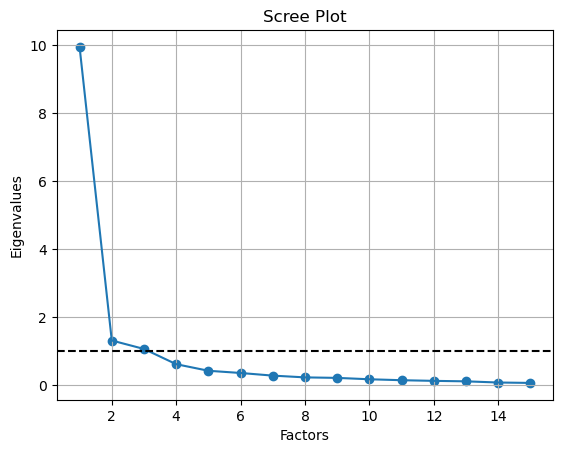

In [998]:
plt.scatter(range(1, df.shape[1]+1), ev)
plt.plot(range(1, df.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, linestyle='--', color='black')
plt.grid()
plt.show()

In [1000]:
alpha = cronbach_alpha(data=df)
alpha

(0.9408789431154513, array([0.94 , 0.942]))

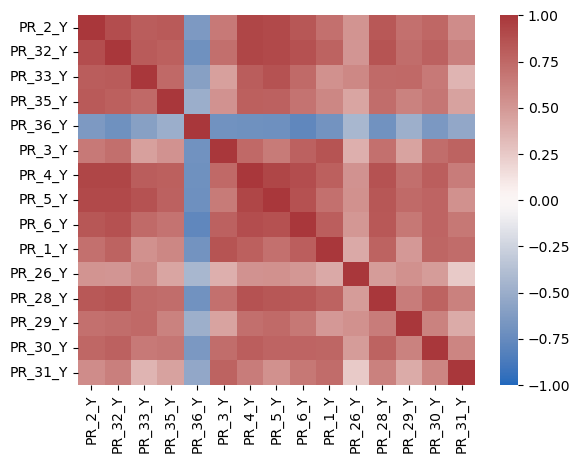

In [1002]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False, cmap='vlag');

In [1004]:
loadings = pd.DataFrame(fa.loadings_, columns = [f'factor_{i+1}' for i in range(n_factors)], index = [df.columns])
loadings

,factor_1,factor_2,factor_3
PR_2_Y,0.888855,0.015229,0.066242
PR_32_Y,0.819672,0.149473,0.036325
PR_33_Y,0.904499,-0.320057,0.296776
PR_35_Y,0.804871,-0.087646,0.115399
PR_36_Y,-0.524360,-0.388252,0.104353
PR_3_Y,0.355199,0.791111,-0.292558
PR_4_Y,0.844229,0.168989,0.004710
PR_5_Y,0.918589,-0.015419,0.088389
PR_6_Y,0.721949,0.339132,-0.077961
PR_1_Y,-0.091342,0.848267,0.216683


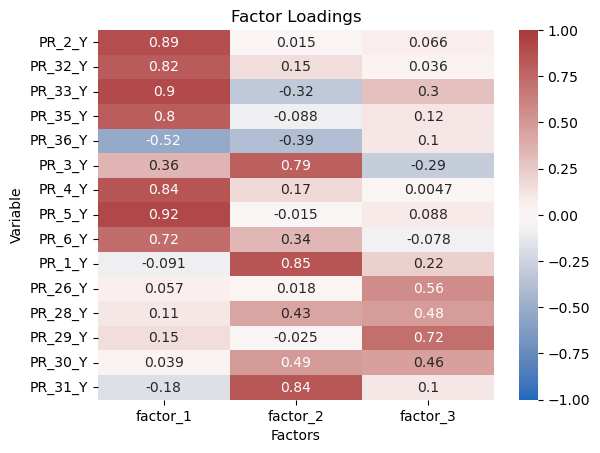

In [1006]:
sns.heatmap(loadings, vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.xlabel('Factors')
plt.ylabel('Variable')
plt.title('Factor Loadings');

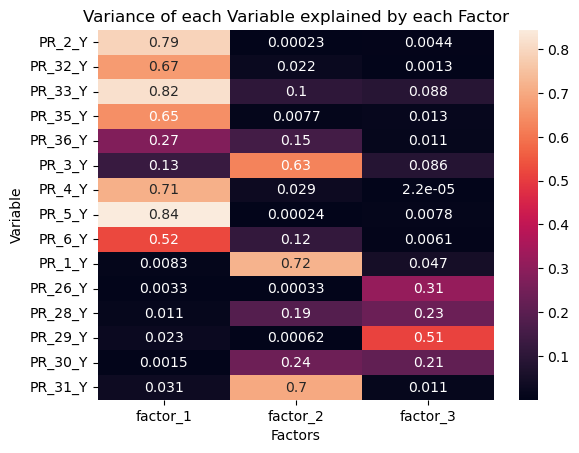

In [1008]:
sns.heatmap(loadings.apply(lambda x: x**2), annot=True)
plt.xlabel('Factors')
plt.ylabel('Variable')
plt.title('Variance of each Variable explained by each Factor');

In [1009]:
factor_var = pd.DataFrame(fa.get_factor_variance(), columns = [f'factor_{i+1}' for i in range(n_factors)], index=['variance', 
                                                                                                          'proportional_variance', 'cumulative_variance'])
factor_var

,factor_1,factor_2,factor_3
variance,5.485544,2.895284,1.548639
proportional_variance,0.365703,0.193019,0.103243
cumulative_variance,0.365703,0.558722,0.661964


In [1012]:
df.isna().any()

PR_2_Y     True
PR_32_Y    True
PR_33_Y    True
PR_35_Y    True
PR_36_Y    True
PR_3_Y     True
PR_4_Y     True
PR_5_Y     True
PR_6_Y     True
PR_1_Y     True
PR_26_Y    True
PR_28_Y    True
PR_29_Y    True
PR_30_Y    True
PR_31_Y    True
dtype: bool

In [1014]:
df = df[(~df['PR_2_Y'].isna()) & 
    (~df['PR_3_Y'].isna()) &
    (~df['PR_4_Y'].isna()) &
    (~df['PR_32_Y'].isna()) &
    (~df['PR_35_Y'].isna()) &
    (~df['PR_26_Y'].isna()) &
    (~df['PR_1_Y'].isna()) &
    (~df['PR_30_Y'].isna()) &
    (~df['PR_26_Y'].isna())]

In [1016]:
df.shape

(16540, 15)

In [1018]:
data = data.fillna(0)

In [1020]:
cppi = pd.DataFrame(fa.transform(df), columns=[f'factor_{i+1}' for i in range(n_factors)], index = df.index)
cppi

,factor_1,factor_2,factor_3
SVPREC_KEY,,,
06001200100,1.511021,2.639086,0.041352
06001200200,1.599163,2.530597,0.229660
06001201400,1.939095,2.580268,0.547768
06001202200,2.243065,2.205786,1.205805
06001202500,2.290975,2.084472,1.899244
...,...,...,...
061010000020,-0.741034,-0.764823,-0.270150
061010000021,-1.540395,-1.397592,-1.011953
061010000022,-1.460540,-1.087401,-0.870493


<Axes: >

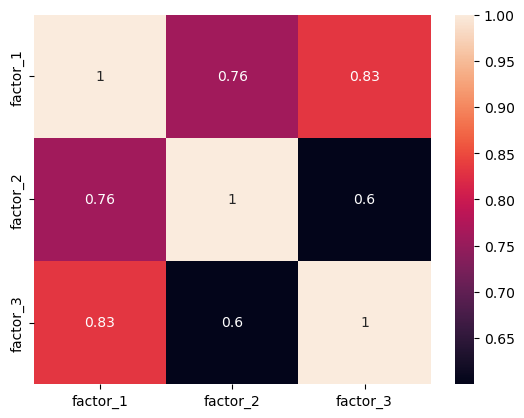

In [1022]:
# Correlation between factors
sns.heatmap(cppi.corr(), annot=True)

In [1024]:
cppi['factor_1'].mean(), cppi['factor_1'].std(), cppi['factor_1'].min(), cppi['factor_1'].max()

(-0.0069654560432556075,
 1.0389434107306497,
 -3.9197126394306943,
 3.27329861661162)

In [1026]:
cppi['factor_2'].mean(), cppi['factor_2'].std(), cppi['factor_2'].min(), cppi['factor_2'].max()

(0.03458171179362025,
 0.9663881160343349,
 -3.685133068101596,
 2.9856995777253665)

In [1028]:
cppi['factor_3'].mean(), cppi['factor_3'].std(), cppi['factor_3'].min(), cppi['factor_3'].max()

(0.047980177999808714,
 0.8385832888550949,
 -4.651469713534969,
 5.375336675291463)

In [1030]:
# # conditional on only using factor 1
# cppi['cppi'] = (cppi['factor_1'] - cppi['factor_1'].min()) / (cppi['factor_1'].max() - cppi['factor_1'].min())
# cppi

In [1032]:
cppi['cppi'] = cppi['factor_1'] + cppi['factor_2'] + cppi['factor_3']
cppi['cppi_unstd'] = cppi['cppi']
cppi['cppi'] = (cppi['cppi'] - cppi['cppi'].min()) / (cppi['cppi'].max() - cppi['cppi'].min())
cppi

,factor_1,factor_2,factor_3,cppi,cppi_unstd
SVPREC_KEY,,,,,
06001200100,1.511021,2.639086,0.041352,0.748739,4.191460
06001200200,1.599163,2.530597,0.229660,0.757386,4.359420
06001201400,1.939095,2.580268,0.547768,0.793820,5.067131
06001202200,2.243065,2.205786,1.205805,0.824067,5.654656
06001202500,2.290975,2.084472,1.899244,0.855988,6.274691
...,...,...,...,...,...
061010000020,-0.741034,-0.764823,-0.270150,0.441524,-1.776007
061010000021,-1.540395,-1.397592,-1.011953,0.329607,-3.949940
061010000022,-1.460540,-1.087401,-0.870493,0.356969,-3.418433


In [1034]:
cppi['cppi'].min(), cppi['cppi'].max(), cppi['cppi'].mean(), cppi['cppi'].std()

(0.0, 1.0, 0.5368478963757636, 0.13291452833734568)

In [1036]:
cppi['fips'] = cppi.index.map(lambda x: x[:5])
cppi.head()

,factor_1,factor_2,factor_3,cppi,cppi_unstd,fips
SVPREC_KEY,,,,,,
06001200100,1.511021,2.639086,0.041352,0.748739,4.191460,06001
06001200200,1.599163,2.530597,0.229660,0.757386,4.359420,06001
06001201400,1.939095,2.580268,0.547768,0.793820,5.067131,06001
06001202200,2.243065,2.205786,1.205805,0.824067,5.654656,06001
06001202500,2.290975,2.084472,1.899244,0.855988,6.274691,06001


In [1038]:
cppi_full = pd.merge(left=cppi.reset_index(), right=full_data, left_on='SVPREC_KEY', right_on='SRPREC_KEY', how='inner')
cppi_full.head()

,SVPREC_KEY,factor_1,factor_2,factor_3,cppi,cppi_unstd,fips,Unnamed: 0,SRPREC_KEY,PR_1_N,...,G24PR3_T,G24PR4_N,G24PR4_Y,G24PR4_Y_2,G24PR5_N,G24PR5_Y,G24PR5_T,G24PR6_N,G24PR6_Y,G24PR6_T
0,06001200100,1.511021,2.639086,0.041352,0.748739,4.191460,06001,0,06001200100,110.394301,...,2920,433,2475,2908,1055,1792,2847,682,2101,2783
1,06001200200,1.599163,2.530597,0.229660,0.757386,4.359420,06001,1,06001200200,84.131590,...,2007,308,1681,1989,671,1264,1935,466,1454,1920
2,06001201400,1.939095,2.580268,0.547768,0.793820,5.067131,06001,2,06001201400,103.578871,...,2933,367,2547,2914,805,2059,2864,589,2225,2814
3,06001202200,2.243065,2.205786,1.205805,0.824067,5.654656,06001,3,06001202200,23.911917,...,405,55,347,402,95,301,396,70,319,389
4,06001202500,2.290975,2.084472,1.899244,0.855988,6.274691,06001,4,06001202500,21.736580,...,648,64,572,636,134,494,628,143,466,609


In [1040]:
# EDA
cnty_cppi = cppi.groupby(['fips'])['factor_1'].agg(['median'])# .sort_values(['median'], ascending=False)
cnty_cppi

,median
fips,
06001,0.823723
06003,0.625360
06005,-1.300088
06007,-0.510092
06009,-1.385905
06011,-1.445262
06013,0.188463
06015,-0.617269
06017,-1.289032


In [1042]:
cnty_f1 = {}
cnty_f2 = {}
cnty_cppi = {}

# cnty_f3 = {}

for i in np.unique(cppi['fips'].values):
    cnty_df = cppi_full[cppi_full['fips'] == i]
    cnty_df['G24PTot'] = cnty_df['G24PTot'] / cnty_df['G24PTot'].sum()
    weighted_avg_f1 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_1'].map(lambda x: x + abs(cnty_df['factor_1'].min()))) - abs(cnty_df['factor_1'].min())
    weighted_avg_f2 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_2'].map(lambda x: x + abs(cnty_df['factor_2'].min()))) - abs(cnty_df['factor_2'].min())
    weighted_avg_cppi = np.sum(cnty_df['G24PTot'] * cnty_df['cppi'])
    cnty_f1.update({i: weighted_avg_f1})
    cnty_f2.update({i: weighted_avg_f2})
    cnty_cppi.update({i: weighted_avg_cppi})
    #weighted_avg_f3 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_3'].map(lambda x: x + abs(cnty_df['factor_3'].min()))) - abs(cnty_df['factor_3'].min())
    #cnty_f3.update({i: weighted_avg_f3})

cnty_cppi

{'06001': 0.6765751652068067,
 '06003': 0.6327802346773901,
 '06005': 0.3783545597491719,
 '06007': 0.4901520473803566,
 '06009': 0.3829278160608079,
 '06011': 0.38573944798458937,
 '06013': 0.5997327449951189,
 '06015': 0.43961319376341174,
 '06017': 0.4175725149474513,
 '06019': 0.46848016547961213,
 '06021': 0.3608378446252711,
 '06023': 0.6103258488756351,
 '06025': 0.5615564351854307,
 '06027': 0.473378326091063,
 '06029': 0.4397948866728153,
 '06031': 0.42744300893468723,
 '06033': 0.5041870285348566,
 '06035': 0.32278939915516247,
 '06037': 0.606396474172369,
 '06041': 0.6421154282268002,
 '06043': 0.41157320707784634,
 '06045': 0.5922773421415686,
 '06047': 0.5017479511839922,
 '06049': 0.31915987412247615,
 '06051': 0.5663531692698625,
 '06053': 0.6109072961478225,
 '06055': 0.5673696240050714,
 '06057': 0.511510547313641,
 '06059': 0.48792957044807994,
 '06061': 0.42270079567628777,
 '06063': 0.41852978972680094,
 '06065': 0.49715953200147506,
 '06067': 0.5590843544329696,
 '

In [1043]:
cnty_f1 = pd.DataFrame(cnty_f1, index=[0]).T.reset_index().rename({'index': 'fips', 0: 'avg_f1'}, axis=1)
cnty_f2 = pd.DataFrame(cnty_f2, index=[1]).T.reset_index().rename({'index': 'fips', 1: 'avg_f2'}, axis=1)
cnty_cppi = pd.DataFrame(cnty_cppi, index=[2]).T.reset_index().rename({'index': 'fips', 2: 'cppi'}, axis=1)
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f1, on='fips', how='inner')
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f2, on='fips', how='inner')
#cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f3, on='fips', how='inner')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2
0,06001,0.676575,0.945905,1.229830
1,06003,0.632780,0.464280,0.813830
2,06005,0.378355,-1.243354,-0.914033
3,06007,0.490152,-0.356974,-0.271275
4,06009,0.382928,-1.267819,-0.866142


In [1046]:
def getCounties():
    "Function to return a dict of FIPS codes (keys) of U.S. counties (values)"
    d = {}
    r = requests.get("http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt")
    reader = csv.reader(r.text.splitlines(), delimiter=',')    
    for line in reader:
        d[line[1] + line[2]] = line[3].replace(" County","")    
    return d

cnty_df = pd.DataFrame(getCounties(), index=[0]).T.reset_index().rename({'index': 'fips', 0:'cnty_name'}, axis=1)
cnty_df.head()

,fips,cnty_name
0,01001,Autauga
1,01003,Baldwin
2,01005,Barbour
3,01007,Bibb
4,01009,Blount


In [1047]:
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_df, on='fips', how='inner')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2,cnty_name
0,06001,0.676575,0.945905,1.229830,Alameda
1,06003,0.632780,0.464280,0.813830,Alpine
2,06005,0.378355,-1.243354,-0.914033,Amador
3,06007,0.490152,-0.356974,-0.271275,Butte
4,06009,0.382928,-1.267819,-0.866142,Calaveras


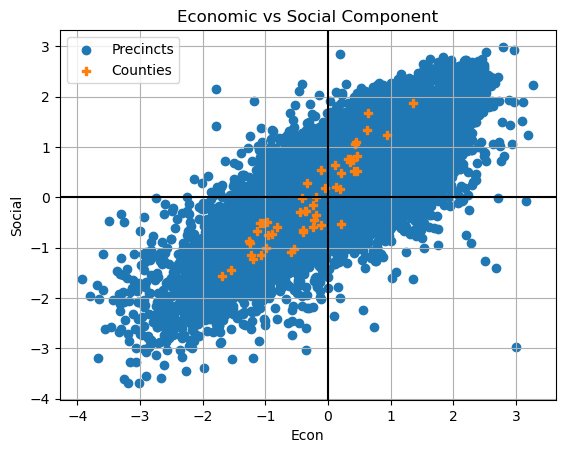

In [1050]:
plt.scatter(cppi['factor_1'], cppi['factor_2'], label='Precincts')
plt.scatter(cnty_cppi['avg_f1'], cnty_cppi['avg_f2'], marker='P', label='Counties')
plt.xlabel('Econ')
plt.ylabel('Social')
plt.title('Economic vs Social Component')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.grid()
plt.legend();

In [1052]:
cppi_full.columns.values

array(['SVPREC_KEY', 'factor_1', 'factor_2', 'factor_3', 'cppi',
       'cppi_unstd', 'fips', 'Unnamed: 0', 'SRPREC_KEY', 'PR_1_N',
       'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N', 'PR_27_Y', 'PR_28_N',
       'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N', 'PR_30_Y', 'PR_31_N',
       'PR_31_Y', 'PR_1_TOT', 'PR_26_TOT', 'PR_27_TOT', 'PR_28_TOT',
       'PR_29_TOT', 'PR_30_TOT', 'PR_31_TOT', 'SRPREC_x', 'FIPS',
       'NEW_KEY', 'SRPREC_y', 'COUNTY', 'FIPS_CODE', 'G24PDem', 'G24PRep',
       'G24POth', 'G24PTot', 'G24SDem', 'G24SRep', 'G24STot', 'G24SSDem',
       'G24SSRep', 'G24SSTot', 'G24HDem', 'G24HRep', 'G24HTot',
       'G24SLDUDem', 'G24SLDURep', 'G24SLDUTot', 'G24SLDLDem',
       'G24SLDLRep', 'G24SLDLTot', 'G24PR2_N', 'G24PR2_Y', 'G24PR2_T',
       'G24PR32_N', 'G24PR32_Y', 'G24PR32_T', 'G24PR33_N', 'G24PR33_Y',
       'G24PR33_T', 'G24PR34_N', 'G24PR34_Y', 'G24PR34_T', 'G24PR35_N',
       'G24PR35_Y', 'G24PR35_T', 'G24PR36_N', 'G24PR36_Y', 'G24PR36_T',
       'G24PR3_N', 'G24PR

In [1054]:
cppi.columns.values

array(['factor_1', 'factor_2', 'factor_3', 'cppi', 'cppi_unstd', 'fips'],
      dtype=object)

Coefficient: [0.14205201], Intercept: 0.4394100567472862
r = [0.97499301]


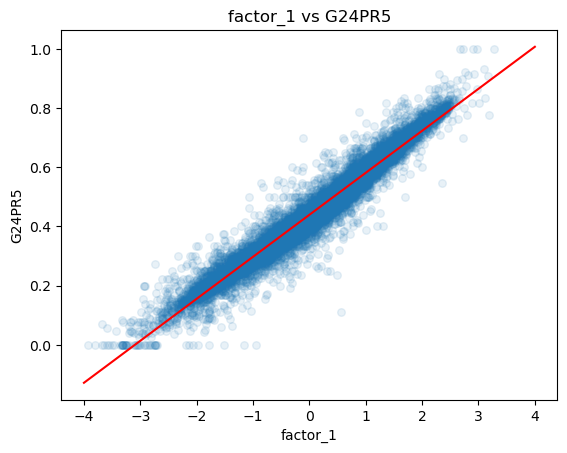

In [1056]:
metric = 'factor_1'
race = 'G24PR5'

race_tot = cppi_full[f'{race}_Y'] + cppi_full[f'{race}_N']

model = lm.LinearRegression().fit(cppi_full[[metric]].values, (cppi_full[f'{race}_Y'] / race_tot).values)
r = r_regression(cppi_full[[metric]], cppi_full[f'{race}_Y'] / race_tot)
print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
print(f'r = {r}')

if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], cppi_full[f'{race}_Y'] / race_tot, alpha=0.1, s=30)
plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
plt.xlabel(metric)
plt.ylabel(race)
plt.title(f'{metric} vs {race}');

Coefficient: [0.05722708], Intercept: 0.5464718964632032
r = [0.88041291]


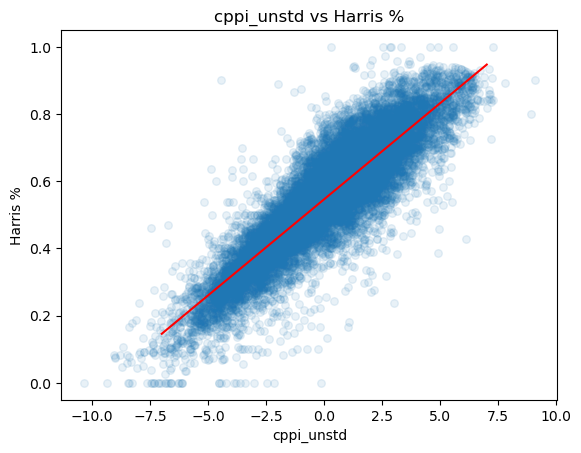

In [1058]:
metric = 'cppi_unstd'
race = 'G24PDem'

race_pct = cppi_full[race] / cppi_full['G24PTot']

model = lm.LinearRegression().fit(cppi_full[[metric]].values, race_pct.values)
r = r_regression(cppi_full[[metric]], race_pct)
print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
print(f'r = {r}')

if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
elif metric == 'cppi_unstd':
    x = np.linspace(-7, 7, 20000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], race_pct, alpha=0.1, s=30)
plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
plt.xlabel(metric)
plt.ylabel('Harris %')
plt.title(f'{metric} vs Harris %');

In [1060]:
## The actual IWAR/VAIR model

In [1062]:
cppi_full['P24_margin'] = cppi_full['G24PDem'] - cppi_full['G24PRep']
metric = 'cppi_unstd'
race = 'P24_margin'

race_pct = cppi_full[race] / cppi_full['G24PTot']
cppi_full['P24_margin'] = race_pct

In [1064]:
def logistic(x, params):
    A, B, C, K, Q, v = params
    y = A + (K - A)/((C + Q*np.exp(-B*x))**(1/v))
    return y

def logistic_fixed(x, B, C, Q, v):
    params = [-1, B, C, 2, Q, v]
    return logistic(x, params)

def loss_fun(x, y, B, C, Q, v):
    params = [-1, B, C, 2, Q, v]
    logistic_res = logistic(x, params)
    loss = np.sum((logistic_res - y)**2)
    return loss

In [1066]:
# x0 = [0.5, 1, 1, 1]
# params = opt.fmin(loss_fun, x0=x0)
# B, C, Q, v = params
# B, C, Q, v, loss_fun(params)

In [1068]:
X = cppi_full[[metric]]
y = race_pct
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def kfold_cv(X_train, y_train, x0, bounds, k=5):
    kf = KFold(n_splits=k)
    losses = []
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        X_fold_train, y_fold_train, X_val, y_val = X_train[metric].values[train_index], y_train.values[train_index], X_train[metric].values[test_index], y_train.values[test_index]
        params, cov = opt.curve_fit(logistic_fixed, X_fold_train, y_fold_train, p0=x0, bounds=bounds)
        B, C, Q, v = params
        val_loss = loss_fun(X_val, y_val, B, C, Q, v)
        losses.append(val_loss)
    return losses 

In [1070]:
x0 = [0.5, 1, 1, 1]
bounds = ([-np.inf, -np.inf, -np.inf, 0], np.inf)
kfold_losses = kfold_cv(X_train, y_train, x0=x0, bounds=bounds, k=5)
print(f'K-Fold CV L2 losses: {kfold_losses}')

params, cov = opt.curve_fit(logistic_fixed, X_train[metric], y_train, p0=x0, bounds=bounds, full_output=False)
B, C, Q, v = params
print(f'B = {B}, C = {C}, Q = {Q}, v = {v}')
print(f'Training set loss: {loss_fun(X_train[metric], y_train, B, C, Q, v)},\n test set loss: {loss_fun(X_test[metric], y_test, B, C, Q, v)}')
print(f'Total loss: {loss_fun(X[metric], y, B, C, Q, v)}')

K-Fold CV L2 losses: [56.84679064414988, 55.35909073434165, 54.79619821563048, 54.74828018555124, 51.773359219836664]
B = 0.16918770503678407, C = 1.000132581172278, Q = 0.0002431225771113943, v = 0.000390080479392678
Training set loss: 273.3548510598559,
 test set loss: 136.40637812163965
Total loss: 409.7612291814955


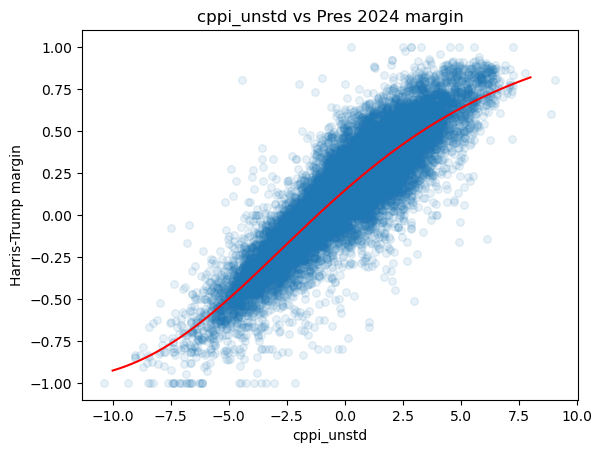

In [1071]:
if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
elif metric == 'cppi_unstd':
    x = np.linspace(-10, 8, 20000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], race_pct, alpha=0.1, s=30)
plt.plot(x, logistic_fixed(x, B, C, Q, v), color='red')
plt.xlabel(metric)
plt.ylabel('Harris-Trump margin')
plt.title(f'{metric} vs Pres 2024 margin');

In [1074]:
logistic(0, [-1, B, C, 2, Q, v])

0.1452798030199236

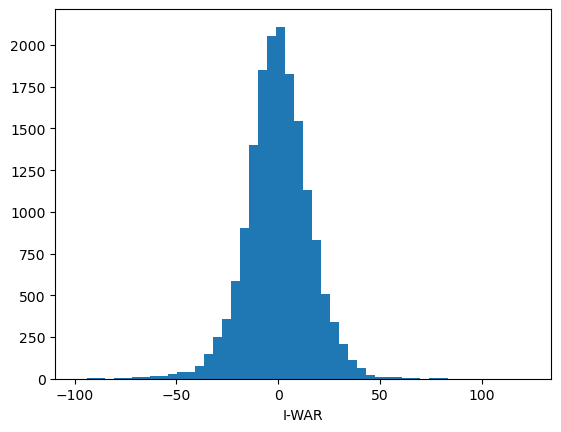

In [1076]:
# We can create a sort of Harris ideological WAR (I-WAR) metric based on this
pred_margin = logistic(cppi_full[metric], [-1, B, C, 2, Q, v])
cppi_full['iwar'] = (cppi_full['P24_margin'] - pred_margin) * 100
cppi = pd.merge(left=cppi.reset_index(), right=cppi_full[['SVPREC_KEY', 'iwar']], on='SVPREC_KEY').set_index(['SVPREC_KEY'])
plt.hist(cppi_full['iwar'], bins=50)
plt.xlabel('I-WAR');

In [1078]:
cppi_full['iwar']

0        28.824990
1        26.684149
2        23.121978
3        10.592690
4        -1.502282
           ...    
16535   -18.300165
16536    -1.096885
16537    -5.566108
16538    -3.109675
16539    -1.697251
Name: iwar, Length: 16540, dtype: float64

In [1080]:
cnty_iwar = {}

for i in np.unique(cppi['fips'].values):
    cnty_df = cppi_full[cppi_full['fips'] == i]
    cnty_df['G24PTot'] = cnty_df['G24PTot'] / cnty_df['G24PTot'].sum()
    weighted_avg_iwar = np.sum(cnty_df['G24PTot'] * cnty_df['iwar'])
    cnty_iwar.update({i: weighted_avg_iwar})
    #weighted_avg_f3 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_3'].map(lambda x: x + abs(cnty_df['factor_3'].min()))) - abs(cnty_df['factor_3'].min())
    #cnty_f3.update({i: weighted_avg_f3})

cnty_iwar

{'06001': 10.88088515191202,
 '06003': -3.8815195967762963,
 '06005': -3.689930294313162,
 '06007': -5.636659791455875,
 '06009': -5.130570717539488,
 '06011': -5.970886732041334,
 '06013': 9.717011351177781,
 '06015': -7.539337261438363,
 '06017': 2.694569413336574,
 '06019': -2.2114280796233956,
 '06021': -6.502296656844013,
 '06023': -1.3020269872501806,
 '06025': -20.518428169358575,
 '06027': -2.458895854399881,
 '06029': -11.744755273760443,
 '06031': -11.181658595704095,
 '06033': -8.743693417082884,
 '06035': -16.090100322738667,
 '06037': 3.951815435776518,
 '06041': 26.25120098447281,
 '06043': -4.435753012184371,
 '06045': 0.19566828440269457,
 '06047': -9.944914440411816,
 '06049': -7.727635410041903,
 '06051': -0.7678410765168974,
 '06053': -0.8593425244449129,
 '06055': 13.140093653786181,
 '06057': 4.010653498440975,
 '06059': -0.09463551928005276,
 '06061': 4.497974795950371,
 '06063': -2.9422246383976804,
 '06065': -6.18250928662021,
 '06067': 0.5833334687376767,
 '060

In [1082]:
cnty_iwar = pd.DataFrame(cnty_iwar, index=[3]).T.reset_index().rename({'index': 'fips', 3: 'iwar'}, axis=1)
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_iwar, on='fips')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2,cnty_name,iwar
0,06001,0.676575,0.945905,1.229830,Alameda,10.880885
1,06003,0.632780,0.464280,0.813830,Alpine,-3.881520
2,06005,0.378355,-1.243354,-0.914033,Amador,-3.689930
3,06007,0.490152,-0.356974,-0.271275,Butte,-5.636660
4,06009,0.382928,-1.267819,-0.866142,Calaveras,-5.130571


In [1084]:
cppi.head()

,factor_1,factor_2,factor_3,cppi,cppi_unstd,fips,iwar
SVPREC_KEY,,,,,,,
06001200100,1.511021,2.639086,0.041352,0.748739,4.191460,06001,28.824990
06001200200,1.599163,2.530597,0.229660,0.757386,4.359420,06001,26.684149
06001201400,1.939095,2.580268,0.547768,0.793820,5.067131,06001,23.121978
06001202200,2.243065,2.205786,1.205805,0.824067,5.654656,06001,10.592690
06001202500,2.290975,2.084472,1.899244,0.855988,6.274691,06001,-1.502282


In [1086]:
df.columns

Index(['PR_2_Y', 'PR_32_Y', 'PR_33_Y', 'PR_35_Y', 'PR_36_Y', 'PR_3_Y',
       'PR_4_Y', 'PR_5_Y', 'PR_6_Y', 'PR_1_Y', 'PR_26_Y', 'PR_28_Y', 'PR_29_Y',
       'PR_30_Y', 'PR_31_Y'],
      dtype='object')

In [1088]:
data.head()

,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,...,PRSREP01,SENDEM01,SENREP01,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
SVPREC_KEY,,,,,,,,,,,,,,,,,,,,,
06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,0.754941,...,0.052912,0.926829,0.073171,0.955874,0.252309,0.104331,0.847685,0.350400,0.599536,0.886794
06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,0.757292,...,0.053223,0.928793,0.071207,0.946099,0.265665,0.094828,0.844839,0.352388,0.627811,0.872772
06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,0.790689,...,0.042454,0.936200,0.063800,0.955950,0.283810,0.106240,0.854969,0.401321,0.667172,0.878068
06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,0.820051,...,0.079625,0.910256,0.089744,0.913043,0.373188,0.178571,0.837456,0.450549,0.746528,0.794326
06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,0.765189,...,0.116519,0.870340,0.129660,0.913502,0.502915,0.230524,0.891263,0.541633,0.740191,0.824003


In [1090]:
np.unique(data.index.map(lambda x: x[:5]))

array(['06001', '06003', '06005', '06007', '06009', '06011', '06013',
       '06015', '06017', '06019', '06021', '06023', '06025', '06027',
       '06029', '06031', '06033', '06035', '06037', '06041', '06043',
       '06045', '06047', '06049', '06051', '06053', '06055', '06057',
       '06059', '06061', '06063', '06065', '06067', '06069', '06071',
       '06073', '06075', '06077', '06079', '06081', '06083', '06085',
       '06087', '06089', '06091', '06093', '06095', '06097', '06099',
       '06101'], dtype=object)

In [1092]:
cnty_cppi.to_csv('cnty_cppi.csv', index=False)
cppi.to_csv('cppi/cppi.csv')